In this notebook, I am going to do data pre-processing. 
1. Imputing missing values
2. Feature Engineering

  - create a 'used year' using 
  - Extract sale year from sale date 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 60.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=720ec5b79bc6403e88fdfd118ac1130134b5a59c4a272fca091b44f970ea05ed
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

In [ ]:
import pandas as pd

In [ ]:
cur_path = "/content/drive/MyDrive/BigData/finalProject/"
os.chdir(cur_path)

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('final').getOrCreate()

In [ ]:
# Import data
data = spark.read.csv(cur_path + 'car_prices.csv',inferSchema=True,header=True)

In [ ]:
data.show()

+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+
|year|     make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|  mmr|sellingprice|            saledate|
+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|        5| 16639.0| white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|        5|  9393.0| white|   beige|kia motors americ...|20800|       21500|Tue Dec

In [ ]:
# Examine the summary of the data
data.summary().show()

+-------+-----------------+------+-----------------+------------------+------------+------------+-----------------+-----------------+------------------+-----------------+-----------------+--------+--------------------+--------------------+------------------+--------------------+
|summary|             year|  make|            model|              trim|        body|transmission|              vin|            state|         condition|         odometer|            color|interior|              seller|                 mmr|      sellingprice|            saledate|
+-------+-----------------+------+-----------------+------------------+------------+------------+-----------------+-----------------+------------------+-----------------+-----------------+--------+--------------------+--------------------+------------------+--------------------+
|  count|           558837|548536|           548438|            548186|      545642|      493484|           558833|           558837|            547043|        

## Missing data

Let's find how many missing data exists in the data and impute them.

In [ ]:
# The number of missing value per column
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65353|  4|    0|    11794|      94|  749|     749|     0|  0|           0|       0|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



In [ ]:
# Total number of missing values in whole dataset
data.count()

558837

In [ ]:
# The percentage of missing values in each column
from pyspark.sql.functions import *
amount_missing_df = data.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1)) * 100).alias(c) for c in data.columns])
amount_missing_df.show()

+----+------------------+-----------------+------------------+-----------------+------------------+-------------------+-----+-----------------+--------------------+-------------------+-------------------+------+---+------------+--------+
|year|              make|            model|              trim|             body|      transmission|                vin|state|        condition|            odometer|              color|           interior|seller|mmr|sellingprice|saledate|
+----+------------------+-----------------+------------------+-----------------+------------------+-------------------+-----+-----------------+--------------------+-------------------+-------------------+------+---+------------+--------+
| 0.0|1.8432924090566658|1.860828828441925|1.9059224782897337|2.361153610086662|11.694465470253402|7.15772219806491E-4|  0.0|2.110454390099439|0.016820647165452538|0.13402834815876544|0.13402834815876544|   0.0|0.0|         0.0|     0.0|
+----+------------------+-----------------+-----

## Creating a bar plot to see the percentage of missing value per column
Now we found that there are many missing values in each column, and we calculated the exact percentage of missing values. Let's make visualziation to see them easily.

In [ ]:
# Convert pyspark format to padnas dataframe format
vis = amount_missing_df.toPandas()

In [ ]:
value = vis.iloc[0].tolist()
name = vis.columns.tolist()

data = {'name': name, 'missing_data': value}
df = pd.DataFrame(data)

In [ ]:
df = df[df['missing_data'] != 0]
df = df.sort_values('missing_data', ascending = False)
df = df.reset_index(drop = True)

In [ ]:
df

,name,missing_data
0,transmission,11.694465
1,body,2.361154
2,condition,2.110454
3,trim,1.905922
4,model,1.860829
5,make,1.843292
6,color,0.134028
7,interior,0.134028
8,odometer,0.016821
9,vin,0.000716


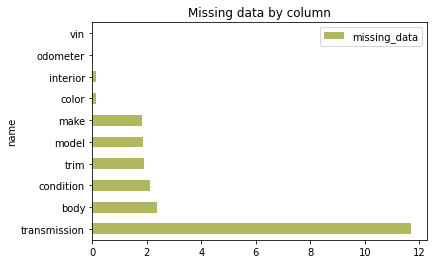

In [ ]:
# Visualization to see how many missing data exists in the data
df.plot.barh(x='name', y='missing_data',
             title='Missing data by column', color='#B0B75E')

We found that the column 'transmission' has the highest percentage of missing value, and its percentage is 11.69%

#Impute Missing Data

## 1) Transmission

Transmission has the largest percent of missing value, which is almost 12%. Other things are less than 3%.

In [ ]:
# Observe the components of transmisison
data.select('transmission').distinct().show()

+------------+
|transmission|
+------------+
|        null|
|   automatic|
|      manual|
|       Sedan|
|       sedan|
+------------+



'Sedan' and 'sedan' represents the same thing, but one is expressed with a capital letter, while the other is expressed with a small letter. Since other category has only small letters, we changed 'Sedan' into 'sedan'.

In [ ]:
# Change 'Sedan' to 'sedan'
data = data.withColumn('transmission', regexp_replace('transmission', 'Sedan', 'sedan'))
data.select('transmission').distinct().show()

+------------+
|transmission|
+------------+
|        null|
|   automatic|
|      manual|
|       sedan|
+------------+



In [ ]:
data.groupBy('transmission').count().show()

+------------+------+
|transmission| count|
+------------+------+
|        null| 65353|
|   automatic|475914|
|      manual| 17544|
|       sedan|    26|
+------------+------+



In [ ]:
# Calculate the percentage of 'automatic' values in this column
475914 / data.count()

data = data.na.fill(value='automatic',subset=["transmission"])

85% of transmission is "automatic". Since majority of cars have an automatic transmission, null data will be filled with "automatic"


## 2) body

In [ ]:
data.select('body').distinct().show()

+--------------------+
|                body|
+--------------------+
|       G Convertible|
|                Koup|
|            Quad Cab|
|             G Sedan|
|          Access Cab|
|        Extended Cab|
|           Hatchback|
|            Club Cab|
|             Ram Van|
|             G Coupe|
|           Q60 Coupe|
|         Convertible|
|         CrewMax Cab|
|                null|
|            King Cab|
|        E-Series Van|
|            Crew Cab|
|          Double Cab|
|          Cab Plus 4|
|         Regular Cab|
|     TSX Sport Wagon|
|            SuperCab|
|                 SUV|
|         CTS-V Coupe|
|               Sedan|
|             Xtracab|
|         convertible|
|           CTS Wagon|
|           SuperCrew|
|       Genesis Coupe|
|               Wagon|
|       Elantra Coupe|
|            Cab Plus|
|                 Van|
|               sedan|
|           CTS Coupe|
|GranTurismo Conve...|
|         CTS-V Wagon|
|  Beetle Convertible|
|            Mega Cab|
|     G37 C

In [ ]:
# Since the body is mixed with capital and lower letter, convert them into lower letter.
from pyspark.sql.functions import lower, col
data = data.withColumn('body', lower(col("body")))

In [ ]:
data = data.withColumn('body', 
   when(data.body.contains('sedan'),'sedan') 
  .when(data.body.contains('suv'),'suv') 
  .when(data.body.contains('cab'),'cab')
  .when(data.body.contains('oup'),'coupe')
  .when(data.body.contains('van'),'van')
  .when(data.body.contains('convertible'),'convertible')
  .when(data.body.contains('wagon'),'wagon')
  .otherwise(data.body))

In [ ]:
data.groupBy('body').count().show(100)

+------------+------+
|        body| count|
+------------+------+
|         van| 31959|
|       wagon| 16180|
|        null| 13195|
|       coupe| 20163|
|         suv|143844|
| convertible| 10933|
|       sedan|248760|
|   hatchback| 26237|
|   supercrew|  9033|
|         cab| 38507|
| navitgation|    26|
+------------+------+



In [ ]:
data = data.na.drop(subset=["body"])

In [ ]:
data.groupBy('body').count().show(100)

+------------+------+
|        body| count|
+------------+------+
|         van| 31959|
|       wagon| 16180|
|       coupe| 20163|
|         suv|143844|
| convertible| 10933|
|       sedan|248760|
|   hatchback| 26237|
|   supercrew|  9033|
|         cab| 38507|
| navitgation|    26|
+------------+------+



## 3) Condition

In [ ]:
data.show()

+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+
|year|     make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|  mmr|sellingprice|            saledate|
+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|        5| 16639.0| white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|      Kia|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|        5|  9393.0| white|   beige|kia motors americ...|20800|       21500|Tue Dec

In [ ]:
avg_con = data.agg({"condition": "avg"}).collect()[0][0]
data = data.fillna(value = str(avg_con), subset = ['condition'])

## 4) Trim

In [ ]:
data.select('trim').distinct().count()

1977

In [ ]:
data.groupBy('trim').count().show()

+--------------------+-----+
|                trim|count|
+--------------------+-----+
|                  LT|16915|
|         G37 Journey| 2902|
|                 hse|    2|
|     C230 Kompressor|  111|
|             Turbo S|   27|
|          caravan se|   25|
|          4x4 ex stx|    9|
|    Laramie Longhorn|   10|
|         2.2 Premium|    7|
|            S Hybrid|   32|
|            LS Fleet| 2361|
|                 VR6|   12|
|            Aveo5 LS|   97|
|                 RTX|   14|
|       MontanaVision|    8|
|2.0T Premium Plus...|  308|
|                PZEV|  100|
|             S65 AMG|   12|
| Special Edition V-6|   40|
|  C320 Luxury 4MATIC|    6|
+--------------------+-----+
only showing top 20 rows



In [ ]:
data = data.na.drop(subset=["trim"])

## 4) Vin

In [ ]:
# drop NA value
data = data.na.drop(subset=["vin"])

## 5) make

In [ ]:
data.groupBy('make').count().show(1530)

+-------------+-----+
|         make|count|
+-------------+-----+
|   Volkswagen|12577|
|   Oldsmobile|  364|
|     Infiniti|15305|
|        Lexus|11861|
|       Jaguar| 1420|
|       Saturn| 2841|
|         FIAT|  865|
|     Maserati|  133|
|        Scion| 1687|
|  Rolls-Royce|   17|
|         Jeep|15372|
|   Mitsubishi| 4140|
|          Kia|18077|
|    Chevrolet|60179|
|        Volvo| 3788|
|      Hyundai|21816|
|         Saab|  484|
|        Honda|27203|
|         MINI| 3224|
|         Audi| 5869|
|          Ram| 4574|
|     Cadillac| 7519|
|        Isuzu|  204|
|     Plymouth|   20|
|      Pontiac| 4497|
|          Geo|   19|
|   Land Rover| 1735|
|Mercedes-Benz|17141|
|      Mercury| 1992|
|       Daewoo|    3|
|      Lincoln| 5757|
|     Chrysler|17276|
|        Tesla|   23|
|          BMW|20719|
|       Suzuki| 1073|
|        Acura| 5901|
|       HUMMER|  805|
|      Ferrari|   19|
|          GMC|10613|
|        Buick| 5107|
|      Porsche| 1383|
|       Fisker|    9|
|        s

In [ ]:
data = data.na.fill('Ford',subset=["make"])

## 6) color

In [ ]:
data.groupBy('color').count().show(1530)

+---------+------+
|    color| count|
+---------+------+
|        —| 24451|
| charcoal|   472|
|turquoise|   224|
| burgundy|  8744|
|   orange|  1986|
|    green| 10796|
|   yellow|  1232|
|     null|   728|
|   silver| 81467|
|   purple|  1507|
|    white|103639|
|     gray| 81525|
|     pink|    42|
|     lime|    15|
|      red| 42525|
|     gold| 10898|
|off-white|  1415|
|    beige|  8905|
|    black|108660|
|    brown|  6611|
|     blue| 49774|
|    14872|     1|
|     4802|     1|
|    12655|     1|
|     1167|     1|
|     9410|     1|
|     2172|     1|
|    15719|     1|
|     6388|     1|
|     2846|     1|
|    18384|     1|
|     6864|     1|
|     5001|     1|
|     9887|     1|
|     9837|     1|
|    18561|     1|
|    11034|     1|
|    20627|     1|
|     6158|     1|
|    16633|     1|
|      339|     1|
|      721|     1|
|     5705|     1|
+---------+------+



In [ ]:
data = data.filter((data.color != '14872') & (data.color != '4802') & (data.color != '12655')& (data.color != '1167')& (data.color != '1167')& (data.color != '9410')& (data.color != '2172')& (data.color != '15719')& (data.color != '6388')& (data.color != '2846')& (data.color != '18384')& (data.color != '6864')& (data.color != '5001')& (data.color != '9887')& (data.color != '9837')& (data.color != '18561')& (data.color != '11034')& (data.color != '20627')& (data.color != '6158')& (data.color != '16633')& (data.color != '339')& (data.color != '721')& (data.color != '5705'))

In [ ]:
data.groupBy('color').count().show(1530)

+---------+------+
|    color| count|
+---------+------+
|        —| 24451|
| charcoal|   472|
|turquoise|   224|
| burgundy|  8744|
|   orange|  1986|
|    green| 10796|
|   yellow|  1232|
|   silver| 81467|
|   purple|  1507|
|    white|103639|
|     gray| 81525|
|     pink|    42|
|     lime|    15|
|      red| 42525|
|     gold| 10898|
|off-white|  1415|
|    beige|  8905|
|    black|108660|
|    brown|  6611|
|     blue| 49774|
+---------+------+



In [ ]:
data = data.withColumn('color', 
    when(data.color.contains('charcoal'),data.color)
   .when(data.color.contains('turquoise'),data.color)
   .when(data.color.contains('burgundy'),data.color)
   .when(data.color.contains('orange'),data.color)
   .when(data.color.contains('green'),data.color)
   .when(data.color.contains('yellow'),data.color)
   .when(data.color.contains('silver'),data.color)
   .when(data.color.contains('purple'),data.color)
   .when(data.color.contains('white'),data.color)
   .when(data.color.contains('gray'),data.color)
   .when(data.color.contains('pink'),data.color)
   .when(data.color.contains('lime'),data.color)
   .when(data.color.contains('red'),data.color)
   .when(data.color.contains('gold'),data.color)
   .when(data.color.contains('off-white'),data.color)
   .when(data.color.contains('beige'),data.color)
   .when(data.color.contains('black'),data.color)
   .when(data.color.contains('brown'),data.color)
   .when(data.color.contains('blue'),data.color)
   .otherwise('black'))

In [ ]:
data.groupBy('color').count().show(1530)

+---------+------+
|    color| count|
+---------+------+
| charcoal|   472|
|turquoise|   224|
| burgundy|  8744|
|   orange|  1986|
|    green| 10796|
|   yellow|  1232|
|   silver| 81467|
|   purple|  1507|
|    white|103639|
|     gray| 81525|
|     pink|    42|
|     lime|    15|
|      red| 42525|
|     gold| 10898|
|off-white|  1415|
|    beige|  8905|
|    black|133111|
|    brown|  6611|
|     blue| 49774|
+---------+------+



## 7) interior

In [ ]:
data.groupBy('interior').count().show(1530)

+---------+------+
| interior| count|
+---------+------+
|        —| 16409|
| burgundy|   184|
|   orange|   135|
|    green|   225|
|   yellow|    20|
|   silver|  1065|
|   purple|   331|
|    white|   244|
|     gray|173443|
|      red|  1312|
|off-white|   480|
|     gold|   314|
|    beige| 58268|
|      tan| 42798|
|    black|240210|
|    brown|  8410|
|     blue|  1040|
+---------+------+



In [ ]:
data = data.withColumn('interior', 
    when(data.interior.contains('burgundy'),data.interior)
   .when(data.interior.contains('orange'),data.interior)
   .when(data.interior.contains('green'),data.interior)
   .when(data.interior.contains('yellow'),data.interior)
   .when(data.interior.contains('silver'),data.interior)
   .when(data.interior.contains('purple'),data.interior)
   .when(data.interior.contains('white'),data.interior)
   .when(data.interior.contains('gray'),data.interior)
   .when(data.interior.contains('red'),data.interior)
   .when(data.interior.contains('off-white'),data.interior)
   .when(data.interior.contains('gold'),data.interior)
   .when(data.interior.contains('beige'),data.interior)
   .when(data.interior.contains('tan'),data.interior)
   .when(data.interior.contains('black'),data.interior)
   .when(data.interior.contains('brown'),data.interior)
   .when(data.interior.contains('blue'),data.interior)
   .otherwise('black'))

In [ ]:
data.groupBy('interior').count().show(1530)

+---------+------+
| interior| count|
+---------+------+
| burgundy|   184|
|   orange|   135|
|    green|   225|
|   yellow|    20|
|   silver|  1065|
|   purple|   331|
|    white|   244|
|     gray|173443|
|      red|  1312|
|off-white|   480|
|     gold|   314|
|    beige| 58268|
|      tan| 42798|
|    black|256619|
|    brown|  8410|
|     blue|  1040|
+---------+------+



## 8) Odometer

In [ ]:
avg_odo = data.agg({"odometer": "avg"}).collect()[0][0]
data = data.na.fill(value=avg_odo,subset=["odometer"])

## 9) Model

In [ ]:
test = data.groupBy('model').count()

In [ ]:
test.orderBy(col("count").desc()).show(truncate=False)

+--------------+-----+
|model         |count|
+--------------+-----+
|Altima        |19426|
|F-150         |14460|
|Fusion        |12904|
|Camry         |12540|
|Escape        |11834|
|Focus         |10368|
|Accord        |9124 |
|3 Series      |8186 |
|Grand Caravan |7937 |
|Impala        |7919 |
|Explorer      |7693 |
|Civic         |7430 |
|G Sedan       |7412 |
|Corolla       |7352 |
|Malibu        |7027 |
|Sonata        |6911 |
|Maxima        |6602 |
|Silverado 1500|6358 |
|Cruze         |6347 |
|Elantra       |6256 |
+--------------+-----+
only showing top 20 rows



In [ ]:
data = data.na.fill(value="Altima",subset=["model"])

In [ ]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+----------+
|year|make|model|trim|body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|madeRegion|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+----------+
|   0|   0|    0|   0|   0|           0|  0|    0|        0|       0|    0|       0|     0|  0|           0|       0|         0|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+----------+



# 2. Feature Engineering

## 1) Vin (Vehicle identification number)
The first 2 letters of Vin means country or region codes. Except this, other information decreases the accuracy of model.

In [ ]:
data = data.withColumn('madeRegion', data.vin.substr(1,2))
data = data.drop('vin')

In [ ]:
data.show()

+----+---------+-------------------+--------------------+-----------+------------+-----+------------------+--------+------+--------+--------------------+-----+------------+--------+----------+
|year|     make|              model|                trim|       body|transmission|state|         condition|odometer| color|interior|              seller|  mmr|sellingprice|saledate|madeRegion|
+----+---------+-------------------+--------------------+-----------+------------+-----+------------------+--------+------+--------+--------------------+-----+------------+--------+----------+
|2015|      Kia|            Sorento|                  LX|        suv|   automatic|   ca|                 5| 16639.0| white|   black|kia motors americ...|20500|       21500|    2014|        5x|
|2015|      Kia|            Sorento|                  LX|        suv|   automatic|   ca|                 5|  9393.0| white|   beige|kia motors americ...|20800|       21500|    2014|        5x|
|2014|      BMW|           3 Series

## 2) Saledate

Saledate consists of day, date, time. However, in car market, only year does matter. For this reason, I am going to remove extra information and leave only year date.

In [ ]:
data.collect()[40][15]

'Wed Feb 04 2015 04:30:00 GMT-0800 (PST)'

In [ ]:
data = data.withColumn('saledate', data.saledate.substr(12,4))

In [ ]:
data.show()

+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+------------------+--------+------+--------+--------------------+-----+------------+--------+----------+
|year|     make|              model|                trim|       body|transmission|              vin|state|         condition|odometer| color|interior|              seller|  mmr|sellingprice|saledate|madeRegion|
+----+---------+-------------------+--------------------+-----------+------------+-----------------+-----+------------------+--------+------+--------+--------------------+-----+------------+--------+----------+
|2015|      Kia|            Sorento|                  LX|        suv|   automatic|5xyktca69fg566472|   ca|                 5| 16639.0| white|   black|kia motors americ...|20500|       21500|    2014|        5x|
|2015|      Kia|            Sorento|                  LX|        suv|   automatic|5xyktca69fg561319|   ca|                 5|  9393.0| white|   beige|kia mo

In [ ]:
data.toPandas().to_csv('/content/drive/MyDrive/BigData/finalProject/cleaned_data.csv')